# Prerequisites   

## Installation  
You will need Python 3.7 (breaking changes in multiprocessing to earlier versions).  
Create a new conda environment and run *setup.py*, which will present you a command line interface.
Please note I am assuming that you have unrestricted access to the Python ecosystem and Google Drive (where I host my larger files). If you don't and require custom steps, please replicate the steps outlined in *setup.py* as appropriate for your custom setting. 

A Hugging Face **Transformer Sentiment Classifier** is implemented. This is transfer learned from a BERT model implementation, which **requires NVIDIA CUDA**. If you want to train the model on your own hardware, do not download my pretrained files provided in *setup.py*. Note that BERT is HUGE (although I've opted for a small model) and might not fit in your GPU, therefore I strongly discourage you from doing so!

All data is available in the ".data" directory unless it is sentiment-related in which case you can find it in ".sentiment".

## Working Principles
Jupyter is great for visualizing results in an orderly manner and notebooks may provide a good overview over a project. On the other hand it discourages writing working code, therefore I have put the majority of the code base into dedicated Python files and classes. This notebook is therefore a summary of the results and I will walk you through the code files if requested during the interview.
Sometimes I also copy redundant code into the Jupyter notebook intentionally to allow for a quicker evaluation from your side.

# Solution
## Task 1: Provide summary statistics and stylized graphs for the twitter data.
First we have to import the supplied CSV-file. The CSV file contains 4678 duplicate rows and 7 rows with very broken content. For making importing the file convenient across the project, I have encapsulated it in a class data which we will import first:

In [1]:
import importlib

In [2]:
from data import Data
data_class = Data()

We can then read the CSV as a pandas-DataFrame object as follows (Ignore the warnings, they are Pandas signalling that there are many issues with the file):
- There are many NaN in the source which can be handeled in two ways: Either by dropping NA (dangerous but may lead to better data quality) or filling them with zeros, which is what I opted for as all counts are lower-bound to zero. Columns of type string still can get dropped later if they are equal to zero, so no information gets lost.
- To be able to convert the dates to a datetime object, I need to drop all items which cannot be converted by the default timestamp (see printouts below).
- Some issues remain in the counts, so I convert them to integers with everything 'weird' being replaced by NaN
- Finally, I can drop the remaining 'weird' entries to obtain df_src

In [3]:
df_src = data_class.load()

D:\Programme\Anwendungen\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In general, summary statistics may be obtained by DataFrame.describe(), however, with mixed datatypes only the numeric ones are included. To display similar information on a more granular level, I have created the custom method 'create_summary_statistics':
- It ensures that describe does not use scientific notation for enhanced readability
- It displays integer timestamps in order not to need a print out of multiple lines of .describe()
- It analyzes simple appearances of words and tickers to give an impression on textual data
- It concatenates the different printouts into a single DataFrame for display  

The result is given below:

In [5]:
summary_statistics = data_class.create_summary_statistics(df_src)
data_class.summary(df_src, summary_statistics)

date   userActivity      replyCount    retweetCount  \
count     1645458.000000  385097.000000  1645458.000000  1645458.000000   
mean   1584431621.673118       4.272840        0.634380        1.650412   
std        767593.767725      66.565977       36.818748       70.563469   
min    1583020800.000000       1.000000        0.000000        0.000000   
25%    1583784026.000000       1.000000        0.000000        0.000000   
50%    1584503234.500000       1.000000        0.000000        0.000000   
75%    1585070685.000000       2.000000        0.000000        0.000000   
max    1585699198.000000   17367.000000    26282.000000    45262.000000   

            likeCount      quoteCount        tickers  
count  1645458.000000  1645458.000000     503.000000  
mean         7.979625        0.268306    3271.288270  
std        528.285166       28.476892   23616.431711  
min          0.000000        0.000000       4.000000  
25%          0.000000        0.000000     257.000000  
50%          0.000000        0.000000     398.000000  
75%          1.000000        0.000000     843.000000  
max     380634.000000    24361.000000  386230.000000

I am also tasked with visualizing this data to get an initial impression. Depending on the type of data I have opted for two different styles: Histograms and Barcharts of item counts. Those are available in plots.py which we will need to import: 

In [6]:
import plots
importlib.reload(plots)
from plots import Plots
plt = Plots()

Now we can generate the required plots. I will use the same columns as are displayed in the column above:

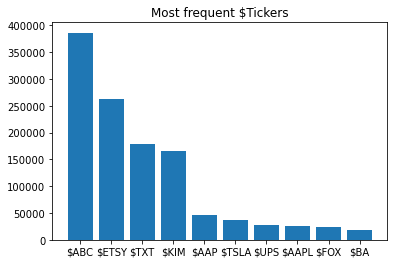

In [7]:
plt.item_count(data_class.count_appearance(df_src["$Ticker"]), title = "Most frequent $Tickers")

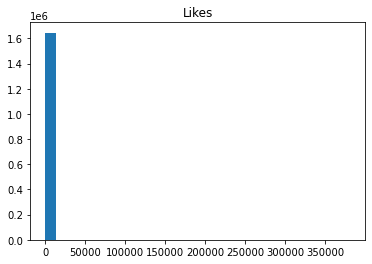

In [8]:
plt.histogram(df_src.likeCount, bins = 30, title = "Likes")

The above shows that our data is severly skewed with huge outliers. We can therefore probably chop off a lot of data especially when dealing with sentiments later on. Zero likes are probably irrelevant for stock market movements (before making such a claim, one should test this though...)

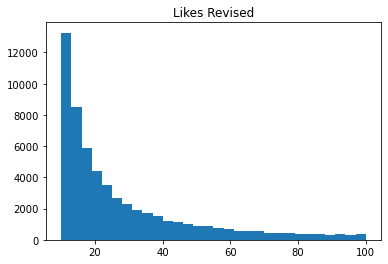

In [9]:
plt.histogram(df_src.likeCount, bins = 30, title = "Likes Revised", upper_cutoff = 100, lower_cutoff = 10)

Now we can run the rest, as it is equivalent:

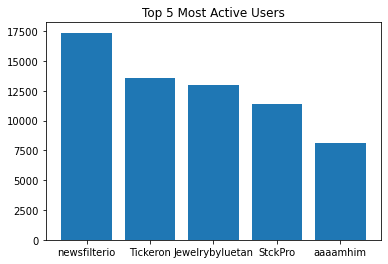

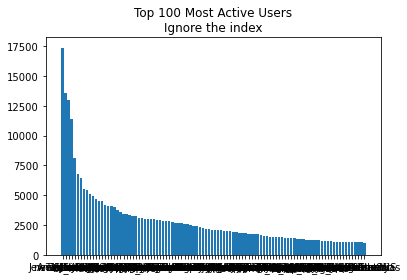

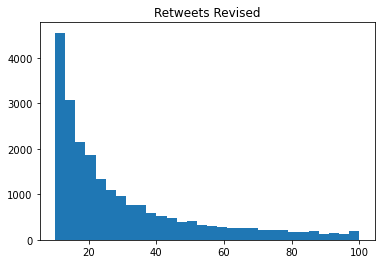

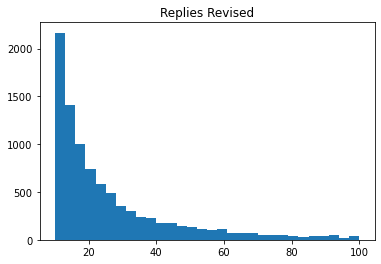

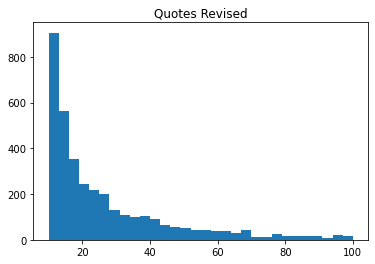

In [10]:
plt.item_count(data_class.count_appearance(df_src["user"]), title = "Top 5 Most Active Users", len_limit = 5)
plt.item_count(data_class.count_appearance(df_src["user"]), title = "Top 100 Most Active Users\nIgnore the index", len_limit = 100)
plt.histogram(df_src.retweetCount, bins = 30, title = "Retweets Revised", upper_cutoff = 100, lower_cutoff = 10)
plt.histogram(df_src.replyCount, bins = 30, title = "Replies Revised", upper_cutoff = 100, lower_cutoff = 10)
plt.histogram(df_src.quoteCount, bins = 30, title = "Quotes Revised", upper_cutoff = 100, lower_cutoff = 10)

## Task 2: Retrieve price information on the stocks mentioned for the relevant time frame from publicly available data sources.
I assume that relevant time frame is about the complete window of available tweets, meaning from (including) March 1 2021 to March 31 2021.

Since we are dealing with Twitter data I presume that the tickers used there are Google Finance. However, the (public & free) Google Finance Api is discontinued for a couple of years now so no way to retrieve stock data from here.
Also StockTwits API documentation has been closed for the public for a couple of weeks. The API is likely going into a revision and may become closed as well :(

The only currently freely available source for daily financial data seems to be yahoo Finance. However, many tickers are named different here, so I need to create a mapping between yahoo Finance and Google Finance tickers.
Since no documentation of StockTwits API is available, I am using requests to call for StockTwits ticker page to retrieve information about each ticker. Then I check yahoo for similar tickers and use the first available one (yes, this is naive, but on a statistical level it should be acceptable for prototype level. One could use quantitative measures such as the *character-error-rate* \[expensive to calculate\] to enhance the results or maintain a database \[out of scope\]).

All these things are available in 'stocks.py' which we will now import:

In [4]:
import stocks
importlib.reload(stocks)
from stocks import Stocks
st = Stocks()

Then I need to obtain a list of tickers which we want to use. While we can extract such a list from the mentioned tickers in a tweet using regex (see key below), this is likely not required if we consider that we are looking at the top 20 mentioned stocks later only. Therefore, I will only use the tickers from the `$Ticker` column to spare me from some grey hair. I have implemented both methods anyways:

In [12]:
print("Regex Key to identify tickers: ", st.ticker_regex_key)
list_of_tickers = st.extract_tickers_from_list(df_src.content, unique = True)
print("Exemplary tickers:", list_of_tickers[:10])
print("Length of extracted tickers:", len(list_of_tickers))

Regex Key to identify tickers:  \$[A-Z]+
Exemplary tickers: ['$NXC', '$HHR', '$WHC', '$NXST', '$AVLIF', '$GWL', '$CBK', '$AESE', '$FPVD', '$PUM']
Length of extracted tickers: 11270


In [13]:
list_of_tickers = list(set(df_src["$Ticker"].to_list()))[1:]
print("Exemplary tickers:", list_of_tickers[:10])
print("Length of supplied set of tickers: ", len(list_of_tickers))

Exemplary tickers: ['$BKR', '$IQV', '$GPS', '$MCK', '$USB', '$DIS', '$GOOG', '$LRCX', '$WLTW', '$TDY']
Length of supplied set of tickers:  502


Yes, there is a considerable difference between these two: For a production model one might probably want to analyze the long set of tickers. However, most of these keys can not be mapped to a yahoo finance key anyways. So let's save us some trouble here.
Now we can create a mapping to from StockTwits to yahoo Finance by calling the following function:

In [62]:
st_yh_mapping = st.gen_twits_yahoo_map(list_of_tickers, fname = None)
# I do not want to save it as I have already created it

Running Procs: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:59<00:00,  8.37it/s]


In [65]:
print("The mapping is a two-way dictionary:", st_yh_mapping.keys())
print("Lets check a few values:", [f"{key}: {st_yh_mapping['ToYahoo'][key]}" for key in st_yh_mapping["ToYahoo"]][:10])

The mapping is a two-way dictionary: dict_keys(['ToYahoo', 'FromYahoo'])
Lets check a few values: ['EL: EL', 'GWW: GWW', 'CAH: CAH', 'XYL: XYL', 'QCOM: QCOM', 'VTR: VTR', 'BIO: BIO', 'AMD: AMD', 'JNJ: JNJ', 'GIS: GIS']


It doesnt look like it with the above sample but the mapping is not perfect. On a statistical level it is okay (not production-ready, of course, since there you need pretty much 100%) and therefore a good starting point :) Now we can obtain stock prices from yahoo via a wrapper for pandas-datareader. It will include unretrievable data rows as NaN and throw a warning. Yahoo does not always have data for their tickers (sometimes even just news), so this is expected behaviour.

**This takes a long time. I am providing an alternative CSV below to make your life a little more convenient.**

In [67]:
stock_prices = st.retrieve_data(list_of_tickers, df_src)

D:\Programme\Anwendungen\Anaconda\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'MAQ.SG', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Programme\Anwendungen\Anaconda\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'ADBE.VI', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Programme\Anwendungen\Anaconda\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'COK-U.TI', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Programme\Anwendungen\Anaconda\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'NEWM.VI', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Programme\Anwendungen\Anaconda\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'DHI.MX', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D

As mentioned, there is no need to download the data, as it is very time consuming. An equivalent CSV can be loaded as follows:

In [5]:
stock_prices = st.load_data()

## Task 3: Determine the 20 most mentioned stocks for each day.
**You should come up with a reasonable metric for mentions beyond simple counts (You are free to consider sentiment information). Provide insight in how you use regex, would set cutoff times for trading days and deal with time zone conventions.**

This is where the aforementioned Transformer comes into play. Conveniently, 'transformer' is also a superior library by the world-renowned NLP-startup *Hugging Face* which allows for applying transfer learning on pretrained models hosted on their website.

Transfer learning means to use a model which was trained on a similar task and then train it with different parameters on the task you would like to solve. The model I propose utilizes the BERT (*Bidirectional Encoder Representations from Transformers*) architecture introduced by Jacob Devlin (Google) in 2018. I start with a pretrained model from https://huggingface.co/prajjwal1/bert-small-mnli which was optimized for text classification.

In order to train my own model, I need to get a labeled dataset. StockTwits provides sentiment information with some tweets. But as the StockTwits-API docu is unavailable for the public right now, I have two options: Use the public API and infer its use from the network monitor in my browser or scrape the site. However, if you have the choice you should always prefer an API to scraping, which can be done as follows:

In [69]:
from sentiment_dataset import get_sentiment_dataset

In [70]:
sentiment_dataset = get_sentiment_dataset(list_of_tickers)

Scraping StockTwits: 100%|███████████████████████████████████████████████████████████| 502/502 [02:38<00:00,  3.17it/s]


We can use this dataset for training. Fitting BERT in an average GPU is not easy, however. **I am providing you with pretrained models and a pre-predicted dataset** for this reason.

In any case, steps for setting up the training process yourself are as follows:
- Install CUDA 11.4 on a headless server with a CUDA-compatible GPU and at least 8GB VRAM
- Delete the `.sentiment`-Folder
- Put `sentiment_dataset.csv` into a clean `.sentiment`-Folder
- Make sure that no other processes require your GPU (BERT is huge!)
- Run `sentiment_transformers.py`

*Since I don't have a headless Windows-device, this is only tested with Linux Ubuntu 20.04.*

In any case, run the following lines ONLY on a CUDA-compatible device (**You don't need to do this as it takes hours. I provide you the labeled dataset**):

In [3]:
import sentiment_transformers
importlib.reload(sentiment_transformers)
from sentiment_transformers import SentimentTransformers

Start the **training process** with the lines below. *Mind to clear the folder `.sentiments` beforehand*  
I don't want to employ shutil.rmtree() this since it could cause you inconveniences.

In [4]:
confirm = input("""Training will only work if you have CUDA (11.4) enabled.
To get CUDA you need a compatible NVIDIA GPU. Confirm with 'y' to acknowledge: """)
if confirm == "y":
    sent = SentimentTransformers()
    def model_init():
         return BertForSequenceClassification.from_pretrained(sent.model_name, num_labels = len(sent.mapping["string"].keys()), return_dict = True).to("cpu")
    #_int.train(autotune = True, model_init = model_init)
    sent.train()

Training will only work if you have CUDA (11.4) enabled.
To get CUDA you need a compatible NVIDIA GPU. Confirm with 'y' to acknowledge: y


***** Running training *****
  Num examples = 9480
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4744


***** Running Evaluation *****
  Num examples = 2370
  Batch size = 20
Saving model checkpoint to .sentiments/results/checkpoint-1000
Configuration saved in .sentiments/results/checkpoint-1000/config.json
Model weights saved in .sentiments/results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2370
  Batch size = 20
Saving model checkpoint to .sentiments/results/checkpoint-2000
Configuration saved in .sentiments/results/checkpoint-2000/config.json
Model weights saved in .sentiments/results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2370
  Batch size = 20
Saving model checkpoint to .sentiments/results/checkpoint-3000
Configuration saved in .sentiments/results/checkpoint-3000/config.json
Model weights saved in .sentiments/results/checkpoint-3000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2370
  Batch size = 20
Saving model checkpoint to .sentiments/results/checkpoint-4000
Configuration saved 

Configuration saved in .sentiments/sentiments_model/config.json
Model weights saved in .sentiments/sentiments_model/pytorch_model.bin
tokenizer config file saved in .sentiments/sentiments_model/tokenizer_config.json
Special tokens file saved in .sentiments/sentiments_model/special_tokens_map.json


In [10]:
# Only uncomment once you want to waste long hours predicting a new dataset
from sentiment_transformers import SentimentTransformers
from tqdm import tqdm
import os

sent = SentimentTransformers()
sentiments = []
for content in tqdm(df_src.content.values, desc = "Extract Sentiments"):
    sentiments.append(sent.predict(content))
incl_sent = df_src
incl_sent["sentiment"] = sentiments
incl_sent.to_csv(os.path.join(".sentiments", "src_data_incl_sentiments.csv"), encoding = "utf-8-sig", index = False)

using `logging_steps` to initialize `eval_steps` to 1000
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Extract Sentiments:   0%|                                         | 0/1645458 [00:00<?, ?it/s]Didn't find file .sentiments/sentiments_model/added_tokens.json. We won't load it.
loading file .sentiments/sentiments_model/vocab.txt
loading file .sentiments/sentiments_model/tokenizer.json
loading file None
loading file .sentiments/sentiments_model/special_tokens_map.json
loading file .sentiments/sentiments_model/tokenizer_config.json
loading configuration file .sentiments/sentiments_model/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small-mnli",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attent

We can load the pre-supplied dataset as follows:

In [10]:
import pandas as pd
import os
data_src_sent = pd.read_csv(os.path.join(".sentiments", "src_data_incl_sentiments.csv"))

The classification is of course not perfect. The problem, however, is not the model, but rather the dataset which includes tweets from just a single day. The model is proven on other use cases on larger data, but with bert-large instead of this tiny model. Let's take a look:

In [25]:
[i for i in data_src_sent[data_src_sent.sentiment == "Bullish"].head().content]

['$MMM has a poor technical rating and the quality of the setup is also only medium at the moment. https://t.co/TiYFeX5ssA https://t.co/9aWTcDAlOy',
 '@LSValue $APT is a well-run company. Should be trivial for them to invest in a lot machinery with a solid government contract. For competitors, there are obstacles to n95 production. Requires certification, and there is some level of IP involved. Big players like $MMM are scaling up...5/n',
 'Let’s get some free 3M stock! $MMM https://t.co/rvQ70rWpfc',
 "@DznBkr Admittedly, I don't know $MMM well so correct me if I'm wrong, but I would have thought that expensive(?) meal kits would be the first thing to be cut from family budgets in a recession.",
 '@jimcramer if I got 1320 laying around is it worth me getting my feet wet &amp; buying 10 shares of $MMM ? Pay dividend , long term investment? Or I’m 31 their is better risk reward out there?']

In [26]:
[i for i in data_src_sent[data_src_sent.sentiment == "Neutral"].head().content]

['$MMM: 3M provides details about capacity increases of N95 respirators https://t.co/7vvnShJhHJ',
 'New York has mores  #CoronavirusUSA 75k to Germany 71K $GILD $ABT $GM $F $MMM $GE $OMI $CAH $UNH',
 'US markets returns for April/2Q: $spy $dia $uco $gld $iwm $ezu $smh $fxi $xly $xlp $xlb $xli $xlu $xlv $xlf $xle $xlk $jpm $axp $gs $xom $cvx $bp $ba $cat $mmm $ups $vz $dis $hd $nke $ko $jnj $mrk $aapl $twtr $tsla $nflx $amzn $intc $msft $amd $wynn $bud $rcl $aal $fcx',
 '📅 April Earnings. Which ones will you be watching? \n$CHWY $WBA $NFLX $KMX $STZ $BAC $LW $JPM $F $INTC $GE $JNJ $PVH $UNF $MMM $WFC $T $BBBY $PG $QCOM $C $TWTR $VZ $AMAT $UNH $GS $AYI $ABT $BIIB $SMPL $CMG $TSM $JFIN $MO $HAL $PFE $VLO $APOG $NG $SCHN $ASND $ERIC https://t.co/5wl8yptfMt',
 '3M ramping up N95 respirators to reach 50M per month in June https://t.co/UyVSk84APE $MMM, $F Great Dividend Stock BUY MMM!']

In [27]:
[i for i in data_src_sent[data_src_sent.sentiment == "Bearish"].head().content]

['$MMM needs to step up. #COVID https://t.co/QAcikiAiQA',
 '$NSPX breaking out 4 cent break today!💸 #COVID19 $LOW $TWTR $LLY $ABMD $RHT $MCD $TTWO $UTX $CL $DWDP $PEP $PYPL $CELG $COST $TE $MMM $ETE $SLB $ASML $PNC $CVS\xa0$BABA $MGM $LVS $CHK $ACB $HMNY $SQ $VALE $TE $PSSI $JD $BZUN $TSM $HD $FNMA $DRYS $AMD $CAT $EBAY $IBM $GDX $LVS $V $C https://t.co/pWvgvryPjQ',
 '@stoolpresidente Just buy $MMM and wait for it to sky rocket. Might take 2 weeks. You’re welcome',
 'Still too slow, we need 100 times production to help us unlock the towns - #Coronavirus leaves 3M and Honeywell to cover N95 face mask shortages $mmm https://t.co/8OCWw6aoil',
 '$MMM 135.75 breaks']

To define a score for obtaining the 20 most mentions of a stock beyond simple word one should optimize for processing the tweets which are more likely to move the market than others. These should have high counts for likes and at least one retweet. Therefore I have decided for the following cutoffs:
1. Remove all data without a re-tweet
2. Only use data with above median like counts from the remainder

Then we can calculate a score from the remainder. I assume that likes are unidirectional positive while lots of comments may indicate that a post is controversial. Therefore I define the ranking as in the function below:

In [6]:
from portfolio import Portfolio
import numpy as np
from tqdm import tqdm

portfolio_class = Portfolio()

# This is a method of Portfolio() 
def calculate_ranking(portfolio_class, dataset, list_of_tickers, verbose = False):
    # First, only use tweets with positive retweetCount
    # From these, obtain a median cutoff for the likeCount
    # Only consider the upper halve
    log_likes = np.log(1 + dataset.likeCount) # Likes are positive
    log_comments = np.log(1 + dataset.replyCount) # Comments are probably more negative
    dataset["likeCommentRatio"] = log_likes/log_likes.max() - log_comments/log_comments.max()
    log_retweets = np.log(1 + dataset.retweetCount)
    dataset["retweetWeight"] = log_retweets/log_retweets.max()
    score = pd.Series(np.zeros(len(list_of_tickers)), name = "score", index = list_of_tickers)
    appearances, found_tickers = portfolio_class.count_ticker_appearance(dataset, list_of_tickers, None, True)
    iterator = tqdm(list_of_tickers) if verbose else list_of_tickers
    for ticker in iterator:
        ticker_in_content = portfolio_class.ticker_appears_in_contents(dataset, ticker, found_tickers)
        score[ticker] = appearances[ticker] * dataset.likeCommentRatio[ticker_in_content].mean() * dataset.retweetWeight[ticker_in_content].mean()
    return score.sort_values(ascending = False)

In [7]:
from datetime import datetime

# Choose an arbitrary day to compute your 20-stocks-portfolio
day = datetime(2020,3,3)

from_date, to_date = portfolio_class.get_trading_times(day, 8, 22)

df_subsample = df_src[df_src.date >= from_date]
df_subsample = df_subsample[df_subsample.date <= to_date]

portfolio_class.calculate_ranking(df_subsample, list_of_tickers, True)[:20] # <- Its 20 Tickers

100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 318.02it/s]


$TSLA     3.716447
$AAPL     1.533388
$AMZN     1.472304
$FB       1.355269
$MSFT     1.322072
$NFLX     1.271769
$TGT      1.182191
$AMD      0.979754
$NVDA     0.743880
$ADBE     0.705044
$GE       0.700134
$BIIB     0.670988
$GOOGL    0.633713
$GILD     0.598946
$ORCL     0.590095
$CRM      0.563330
$MU       0.544530
$TWTR     0.543748
$LEN      0.526280
$PG       0.524894
Name: score, dtype: float64

If you iterate this more often you realize that the 20-stocks portfolio will become almost Buy&Hold :)

**Where is the Sentiment you may ask?**  
We'll use it for the Total-Return-Index of the 20-Stocks portfolio later. The dataframe can then be further filtered if required to compare a situation with and without.

**Provide Information on Regex**  
I use Regex for cleaning the data when training sentiments in sentiments_transformer.py:

In [148]:
def clean_text(string):
    # Remove URLs
    string = re.sub("""((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*""", "", string) 
    # Remove weird tags
    string = re.sub("@.+:", "", string)
    string = re.sub("\(", "", string)
    string = re.sub("\)", "", string)
    # Remove Stock tickers: Potential danger for bias, say if a stock has negative news on the train set but
    # is charmed on the test set the model may infer from the ticker that sentiment is generally negative
    # Looking at you, Nikola
    string = re.sub("\$[A-Z]+", "", string)
    # Ultimately I only leave what I really need and lowercase everything
    string = " ".join(re.findall("[a-zA-Z]+ *", string)).lower()
    return string

## Task 4: Construct a total return index of the 20 daily most mentioned stocks and compare it to the S&P 500 index.
**Elaborate on the weighting and rebalancing used for the index.**  

Since such an index is relatively radical and throws over the portfolio (although the most mentioned stocks do not change so dramatically) I will use equal weighting on the portfolio. This implies an active trade at the end of each day if the return is not 0%.  
Thus, I reserve one hour of computing for retrieving the data labeling sentiment, calculating the score, preparing the trades.  
Yahoo Finance's prices open at 02:00:00 AM UTC and close at 23:59:59 PM UTC. That's the appropriate closing open and closing times for the underlying price data.  
However, at least in Austria it is unlikely that you can trade the same times. One of the longest opening times is offered by Munich-based exchange *gettex* from 08:00 CET to 22:00 CET. I will therefore pretend as if my Yahoo prices match this time even though that is not correct, of course.  

In [8]:
import portfolio
importlib.reload(portfolio)
from portfolio import Portfolio
import os

I am using Yahoo Finance data for ^GSPC as S&P 500 to benchmark the portfolios. We can collect the S&P 500 Data like such (the data is provided as well, no need to run this):

In [7]:
spx = st.import_stocks(["^GSPC"], "2020-03-01", "2020-03-31")
spx.to_csv(os.path.join(st.data_folder, "spx.csv"), encoding = "utf-8-sig")

Since this code clutters this notebook unnecessarily, I will walk you through the class in our interview. To calculate the returns, we simply need to run:

Gen TotalReturn-Index: 100%|███████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.31it/s]


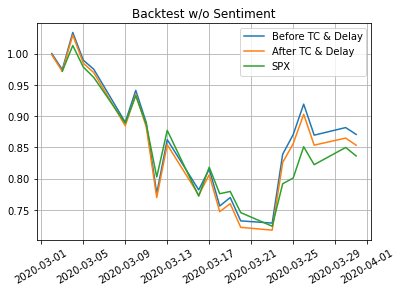

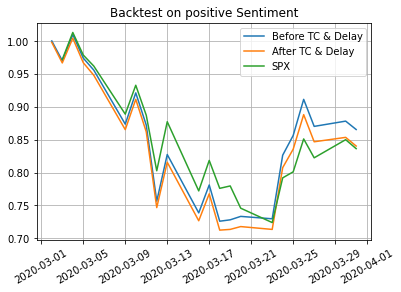

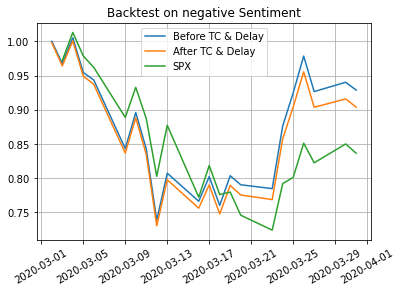

In [10]:
import pandas as pd

stock_prices = st.load_data()
pf = Portfolio()
gross_totret, net_totret = pf.total_return_20_stocks(df_src, stock_prices)
_, _, spx = pf.plot_results(gross_totret, net_totret, "Backtest w/o Sentiment")
# Positive Sentiment
df_sent = pd.read_csv(os.path.join(".sentiments", "src_data_incl_sentiments.csv"))
gross_totret_pos, net_totret_pos = pf.total_return_20_stocks(df_sent, stock_prices, require_sentiment = "Bullish")
_, _, spx = pf.plot_results(gross_totret_pos, net_totret_pos, "Backtest on positive Sentiment")
gross_totret_neg, net_totret_neg = pf.total_return_20_stocks(df_sent, stock_prices, require_sentiment = "Bearish")
_, _, spx = pf.plot_results(gross_totret_neg, net_totret_neg, "Backtest on negative Sentiment")

Obviously, the top-notch silicon valley firms will always be on top when it comes to tweeting about them on social media. Therefore it is no surprise that the sentiment does not hugely impact the overall looks of the chart.
Clearly, S&P 500 volatility is lower than the 20 portfolios' volatility sampled here. This is no surprise, as the S&P 500 enjoys portfolio effects of 480 more stocks.

It seems as if Sentiment would have a mean reversing effect: Since we buy stocks up to one day upon observing their sentiment, it is not completely implausible either. It also seems as if negative sentiment has a stronger effect than positive sentiment. Even though obviously this is not enouigh data, we should verify our suspicions!

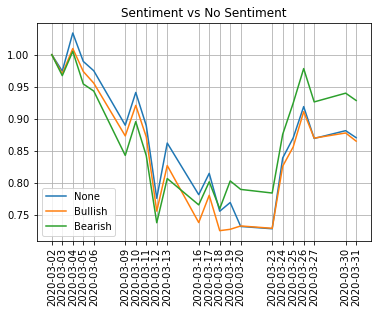

In [11]:
from matplotlib import pyplot
pyplot.figure()
pyplot.plot(gross_totret)
pyplot.plot(gross_totret_pos)
pyplot.plot(gross_totret_neg)
pyplot.xticks(gross_totret.index, rotation = 90)
pyplot.title("Sentiment vs No Sentiment")
pyplot.grid()
pyplot.legend(["None", "Bullish", "Bearish"])

...and it's a good thing we checked! Here we can see that the situation gets inverted to the mid of the month (note that the chart is grouped by trading days for better visibility here)

In [13]:
print("Default Portfolio:", pf.portfolio_characteristics(gross_totret, len(gross_totret)))
print("Positive Sentiment Portfolio:", pf.portfolio_characteristics(gross_totret_pos, len(gross_totret_pos)))
print("Negative Sentiment Portfolio:", pf.portfolio_characteristics(gross_totret_neg, len(gross_totret_neg)))
print("S&P 500:", pf.portfolio_characteristics(spx, len(spx)))

Default Portfolio: {'GeoMean': -0.13791021146614701, 'Vola': 0.3271524414367362, 'Sharpe': -0.4215472483118109}
Positive Sentiment Portfolio: {'GeoMean': -0.1440648236023614, 'Vola': 0.3117697644842085, 'Sharpe': -0.4620872195246452}
Negative Sentiment Portfolio: {'GeoMean': -0.07383536842704252, 'Vola': 0.3006466455172998, 'Sharpe': -0.24558853234500463}
S&P 500: {'GeoMean': -0.14963247030200966, 'Vola': 0.2773314408243228, 'Sharpe': -0.5395438391595679}
